In [18]:
import numpy as np
import pandas as pd
import pymatgen as mg
import matplotlib.pyplot as plt
from matminer.featurizers.site import CrystalNNFingerprint,AGNIFingerprints,\
                                      OPSiteFingerprint, VoronoiFingerprint,\
                                      GeneralizedRadialDistributionFunction
from matminer.featurizers.composition import ValenceOrbital 
from matminer.featurizers.structure import SiteStatsFingerprint
from matminer.featurizers.conversions import StructureToComposition
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import pairwise_distances,pairwise_distances_argmin
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

%matplotlib inline

C:\Users\Ganesh\Anaconda3\lib\importlib\_bootstrap.py:219: RuntimeWarning:

numpy.ufunc size changed, may indicate binary incompatibility. Expected 216, got 192

C:\Users\Ganesh\Anaconda3\lib\importlib\_bootstrap.py:219: RuntimeWarning:

numpy.ufunc size changed, may indicate binary incompatibility. Expected 216, got 192

C:\Users\Ganesh\Anaconda3\lib\importlib\_bootstrap.py:219: RuntimeWarning:

numpy.ufunc size changed, may indicate binary incompatibility. Expected 216, got 192



In [6]:
def init_mprester():
    """
    Define The API object that is responsibile for connecting to the Materials Project back-end
    
    Keyword Arguments:
        None
    
    Returns:
        MPRester object
    """
    
    return mg.MPRester(api_key='zUTBDkOXNL4RpPaQ')

In [7]:
def load_materials_database(mat_type,mpr):
    """
    Create dataset based on choice of material type.
    Queries Materials Project based on datatype to get a list of dicts containing material properties
    Converts this list of dicts to a dataframe
    Each material in the dataframe (each row) of dicts has a unique ID - material_id.
    Using the material_id column, creates a 'structure' column containing Pymatgen structure objects
    Structure objects contain information about atom type, atom positions and relative positions of each atoms' neighbors.
    
    Keyword Arguments: 
        mat_type: str
            One of 'unary','binary','ternary'
        mpr: MPRester object
            Initialized with suitable API key
                           
    Returns:
        Pandas DataFrame containing dataset with 'structure' column.
    """
    
    dbdict = {'unary':'*',
              'binary':'**',
              'ternary':'***'
             }
    #Query Materials Project back-end
    materials_data = mpr.get_data(dbdict[mat_type])
    
    #Convert list of dicts into Pandas DataFrame
    materials_database = pd.DataFrame(materials_data)
    
    #For each material entry in the dataframe, get a pymatgen structure object using mpr.get_structure_by_material_id
    materials_database['structure'] = materials_database['material_id'].apply(lambda x: mpr.get_structure_by_material_id(x))
    
    return materials_database

In [44]:
#For each structure object, get an atomic fingerprint for all atoms in the structure
def get_fingerprint_for_material(structure,site_featurizer):
    """
    Get a fingerprint for each atom in each structure
    
    Keyword Arguments:
        structure: Pymatgen structure object.
           A structure object contains the coordinates for each atom in the structure.
           It also contains information about atom type and how atoms are arranged to form a crystal
        site_featurizer: A matminer site featurizer object.
           Converts structure information into a vector of numbers unique for each unique material.
           This vector is called a 'fingerprint' for that material.
           See https://hackingmaterials.github.io/matminer/featurizer_summary.html for full list of site
           featurizers.
           
    Returns:
        A 1D-numpy array of numbers corresponding to structure object                             
    """
    
    return np.array(site_featurizer.featurize(structure)).reshape((1,-1))

In [8]:
def get_ssf_featurizer(fingerprint_name, stats=('mean')):
    """
    Return a SiteStatsFingerprint object that can compute statistics for each column of the fingerprint 
    for a multi-atom system. For  instance, return a SiteStatsFingerprint object that computes min, max,
    std, mean values of each column in fingerprint for all atoms.
    
    Keyword Arguments:
        fingerprint_name: str
            'CrystalNN' is the only acceptable option for now. Plan to add more in coming iterations.
        stats: tuple of strs
            Choose from 'mean','std_dev','minimum','maximum' for the str options.
    
    Returns:
        SiteStatsFingerprint object corresponding to the Fingerprint name
    """
    
    #Define dict mapping name to fingerprint object
    fingerprint_name_to_obj_dict = {'CrystalNN':CrystalNNFingerprint.from_preset('ops',
                                                                                 distance_cutoffs=None,
                                                                                 x_diff_weight=0),
                                    'GRDF':GeneralizedRadialDistributionFunction.from_preset(preset='gaussian',
                                                                                             spacing=0.1,
                                                                                             width=0.05,
                                                                                             mode='GRDF')
                                   }
    
    return SiteStatsFingerprint(fingerprint_name_to_obj_dict[fingerprint_name],stats=stats)

In [9]:
def get_fingerprint_df_for_db(db,featurizer):
    """
    'Featurizes' a materials dataframe based on Pymatgen structure objects.
    
    Keyword Arguments:
        db:
            Pandas dataframe containing (at minimum) 'structure', 'material_id', 'pretty_formula', 'spacegroup' columns
        featurizer:
            A Pymatgen structure-based featurizer. Full list of structure featurizers at
            https://hackingmaterials.github.io/matminer/featurizer_summary.html
    Returns:
        Pandas dataframe containing site-averaged fingerprints
    """
    # Create a sub-dataframe containing only 'structure' and 'material_id'
    db_struct = db[['structure','material_id','pretty_formula','spacegroup']]
    
    # Featurize the dataframe usinng the featurizer provided
    sitestats_db = featurizer.featurize_dataframe(db_struct,col_id='structure',ignore_errors=True)
    
    # Drop the structure column - this will not be needed in the analysis
    sitestats_db.drop(['structure'],axis=1,inplace=True)
    
    # In case there were errors in the process, np.nan is returned. Fill this with a large number.
    # Alternately, just drop nans in future iterations of this code.
    sitestats_db.dropna(inplace=True)
    
    return sitestats_db

In [10]:
def compute_pairwise_distances(material_fingerprint,fingerprints_database,scale=False):
    """
    Computes Pairwise distances between a target material and a material database using material fingerprints.
    
    Keyword Arguments:
        material_fingerprint: 
            A numpy vector generated using a structure-based matminer featurizers for a selected material
        fingerprint_database: 
            A Dataframe containing fingerprints of the same type as material_fingerprint.
            The Dataframe should be computed using get_fingerprint_df_for_db()
        scale: boolean
            True if the vectors need to be scaled before computing distances. False by default.
            This is preferable since large differences between features can skew distance results.
    
    Returns:
        Vector of pairwise distances between the target material and each material in the database.
    
    """
    
    if(scale==True):
        scaler = StandardScaler()
        Y = scaler.fit_transform(fingerprints_database)
        X = scaler.transform(material_fingerprint)
    else:
        Y = fingerprints_database.values
        X = material_fingerprint

    distances = pairwise_distances(X=X,Y=Y,metric='euclidean')
    
    return distances

In [11]:
def get_fingerprint_db(dbtype,fingerprint_name,stats):
    """
    Create and return a fingerprint database for materials
    
    Keyword Arguments:
        dbtype: str
            The database type for which closest 'n' materials need to be found.
            Valid types are 'unary', 'binary' and 'ternary' for mono, di and tri-atomic systems.
        fingerprint_name: str
            Currently, two types of structural fingerprints are supported - 'CrystalNN' and 'GRDF'
        stats: tuple
            All or any of the options among the following, but in tuple format - 'maximum', 'minimum', 'mean', 'std_dev'
    
    Returns: 
        fingerprints_db: Pandas DataFrame
            Database containing fingerprints for each material in the database corresponding to 'dbtype'
    """
    print('Initializing connection to Materials Project...')
    # Create object to interface with API
    mpr = init_mprester()
    
    print('Creating materials database...')
    # Create materials database
    materials_database = load_materials_database(dbtype,mpr)
    
    print('Creating Site Stats fingerprint object...')
    # Create fingerprint object to compute statistics of fingerprints for all atoms in a structure.
    ssf = get_ssf_featurizer(fingerprint_name,stats=stats)
    
    print('Creating fingerprint database...')
    # Create a fingerprint database for all materials in the materials database
    fingerprints_db = get_fingerprint_df_for_db(db=materials_database,featurizer=ssf)

    return fingerprints_db

In [73]:
def n_closest_materials(material_id,fingerprint_db,fingerprint_name,stats,num_closest):
    """
    Find the closest 'n' materials to a given material.
    
    Keyword Arguments:
        material_id - str
            Valid Materials Project material id.
        fingerprint_db - Python Dataframe
            Database containing fingerprints of materials for which distance computation is sought.
            The database must be numeric, i.e. contain not strings or object columns.
        num_closest - int
            Number of closest neighbors sought.
    
    Returns:
        A numpy array containing distances of target material from each material in the databse
    """
    
    print('Retrieving fingerprint for target material...')
    # Compute fingerprint for target material
    ssf = get_ssf_featurizer(fingerprint_name=fingerprint_name,stats=stats)
    
    mpr = init_mprester()
    
    material_fingerprint = get_fingerprint_for_material(site_featurizer=ssf,
                                                        structure=mpr.get_structure_by_material_id(material_id=material_id))
    
    print('Computing pairwise distances between target material and each material in database...')
    # Compute pairwise distances
    distances = compute_pairwise_distances(fingerprints_database=fingerprint_db,
                                           material_fingerprint=material_fingerprint,
                                           scale=True,
                                          )
    
    print('Distance computation done...')

    closest_neighbors['distance'] = distances.reshape((-1,1))
    closest_neighbors = closest_neighbors.sort_values(ascending=True,by='distance')
    
    print('Returning closest {} neighbors'.format(num_closest))
    
    return closest_neighbors.head(num_closest)

In [27]:
def kmeans_inertia(fingerprints_db,n_cluster_min,n_cluster_max,random_state=42):
    """
    Groups materials using fingerprints using KNN clustering. 
    
    Keyword Arguments:
        fingerprint_db: Pandas DataFrame with all numeric columns
            Database containing fingerprints of materials
        n_cluster_min: int
            Minimum number of clusters to fit and display
        n_cluster_max: int
            Maximum number of clusters to fit and display
        random_state: int
            Random Number seed for KMeans.
    
    Returns:
        None. Simply provides a visual guide to inertia versus number of clusters.
    """
        
    # Drop material_id before computing pairwise distances since it is of str type
    #fingerprints_db_no_material_id = fingerprints_db.drop(columns=['material_id'],axis=1)
    
    # Performing KMeans clustering on the fingerprint database
    print('Performing KMeans clustering on fingerprint database...')
    inertia=[]
    num_clusters_sweep = list(range(n_cluster_min,n_cluster_max))
    for n_clusters in num_clusters_sweep:
        kmeans_obj = KMeans(n_clusters=n_clusters)
        kmeans_obj.fit(fingerprints_db)
        inertia.append(kmeans_obj.inertia_)
    
    plt.plot(num_clusters_sweep,inertia,'o-')
    plt.xlabel('Number of clusters')
    plt.ylabel('Inertia')
    plt.xticks(num_clusters_sweep)
    plt.show()
    
    return

In [32]:
def perform_nD_projection(fingerprints_db,n_dimensions):
    """
    Performs a nD projection for visualization. Uses PCA.
    
    Keyword Arguments:
        fingerprints_db: Pandas DataFrame
            Database containing fingerprints of materials
        n_dimensions: int
            Number of dimensions upon which to project. Should be <= dimensionality of db
            
    Returns: PCA transformed matrix 
    """
    pca = PCA(n_components=n_dimensions)
    proj_nd_mat = pca.fit_transform(fingerprints_db)
    
    return proj_nd_mat

In [22]:
def scale_fingerprints_database(fingerprints_db,scaler=StandardScaler()):
    """
    Scale fingerprints DB
    
    Keyword Arguments:
        fingerprints_db: Pandas DataFrame
            Database containing material fingerprints
        scaler: A Scaler object from sklearn.preprocessing
            Transforms database in desired manner
    
    Returns:
        scaled_fingerprints_db: Numpy Array of same dimensionality as fingerprints_db
            Contains scaled fingerprints
    """
    
    scaled_fingerprints_db = scaler.fit_transform(fingerprints_db)
    
    return scaled_fingerprints_db,scaler

The first order of business is to create the fingerprint database. For the sake of this article, let's start with elemental materials.

In [76]:
fingerprint_db = get_fingerprint_db(dbtype='unary',fingerprint_name='GRDF',stats=('mean')) #Create fingerprint DB for elemental materials from the Materials Project

Initializing connection to Materials Project...
Creating materials database...
Creating Site Stats fingerprint object...
Creating fingerprint database...


Having created the database, it's good to have a snapshot of the database features and see if there are any major outliers.

In [70]:
fingerprint_db.describe() #Get a snapshot of the stats for the db

,mean Gaussian center=0.0 width=0.05,mean Gaussian center=0.1 width=0.05,mean Gaussian center=0.2 width=0.05,mean Gaussian center=0.30000000000000004 width=0.05,mean Gaussian center=0.4 width=0.05,mean Gaussian center=0.5 width=0.05,mean Gaussian center=0.6000000000000001 width=0.05,mean Gaussian center=0.7000000000000001 width=0.05,mean Gaussian center=0.8 width=0.05,mean Gaussian center=0.9 width=0.05,mean Gaussian center=1.0 width=0.05,mean Gaussian center=1.1 width=0.05,mean Gaussian center=1.2000000000000002 width=0.05,mean Gaussian center=1.3 width=0.05,mean Gaussian center=1.4000000000000001 width=0.05,mean Gaussian center=1.5 width=0.05,mean Gaussian center=1.6 width=0.05,mean Gaussian center=1.7000000000000002 width=0.05,mean Gaussian center=1.8 width=0.05,mean Gaussian center=1.9000000000000001 width=0.05,mean Gaussian center=2.0 width=0.05,mean Gaussian center=2.1 width=0.05,mean Gaussian center=2.2 width=0.05,mean Gaussian center=2.3000000000000003 width=0.05,mean Gaussian center=2.4000000000000004 width=0.05,mean Gaussian center=2.5 width=0.05,mean Gaussian center=2.6 width=0.05,mean Gaussian center=2.7 width=0.05,mean Gaussian center=2.8000000000000003 width=0.05,mean Gaussian center=2.9000000000000004 width=0.05,mean Gaussian center=3.0 width=0.05,mean Gaussian center=3.1 width=0.05,mean Gaussian center=3.2 width=0.05,mean Gaussian center=3.3000000000000003 width=0.05,mean Gaussian center=3.4000000000000004 width=0.05,mean Gaussian center=3.5 width=0.05,mean Gaussian center=3.6 width=0.05,mean Gaussian center=3.7 width=0.05,mean Gaussian center=3.8000000000000003 width=0.05,mean Gaussian center=3.9000000000000004 width=0.05,mean Gaussian center=4.0 width=0.05,mean Gaussian center=4.1000000000000005 width=0.05,mean Gaussian center=4.2 width=0.05,mean Gaussian center=4.3 width=0.05,mean Gaussian center=4.4 width=0.05,mean Gaussian center=4.5 width=0.05,mean Gaussian center=4.6000000000000005 width=0.05,mean Gaussian center=4.7 width=0.05,mean Gaussian center=4.800000000000001 width=0.05,mean Gaussian center=4.9 width=0.05,mean Gaussian center=5.0 width=0.05,mean Gaussian center=5.1000000000000005 width=0.05,mean Gaussian center=5.2 width=0.05,mean Gaussian center=5.300000000000001 width=0.05,mean Gaussian center=5.4 width=0.05,mean Gaussian center=5.5 width=0.05,mean Gaussian center=5.6000000000000005 width=0.05,mean Gaussian center=5.7 width=0.05,mean Gaussian center=5.800000000000001 width=0.05,mean Gaussian center=5.9 width=0.05,mean Gaussian center=6.0 width=0.05,mean Gaussian center=6.1000000000000005 width=0.05,mean Gaussian center=6.2 width=0.05,mean Gaussian center=6.300000000000001 width=0.05,mean Gaussian center=6.4 width=0.05,mean Gaussian center=6.5 width=0.05,mean Gaussian center=6.6000000000000005 width=0.05,mean Gaussian center=6.7 width=0.05,mean Gaussian center=6.800000000000001 width=0.05,mean Gaussian center=6.9 width=0.05,mean Gaussian center=7.0 width=0.05,mean Gaussian center=7.1000000000000005 width=0.05,mean Gaussian center=7.2 width=0.05,mean Gaussian center=7.300000000000001 width=0.05,mean Gaussian center=7.4 width=0.05,mean Gaussian center=7.5 width=0.05,mean Gaussian center=7.6000000000000005 width=0.05,mean Gaussian center=7.7 width=0.05,mean Gaussian center=7.800000000000001 width=0.05,mean Gaussian center=7.9 width=0.05,mean Gaussian center=8.0 width=0.05,mean Gaussian center=8.1 width=0.05,mean Gaussian center=8.200000000000001 width=0.05,mean Gaussian center=8.3 width=0.05,mean Gaussian center=8.4 width=0.05,mean Gaussian center=8.5 width=0.05,mean Gaussian center=8.6 width=0.05,mean Gaussian center=8.700000000000001 width=0.05,mean Gaussian center=8.8 width=0.05,mean Gaussian center=8.9 width=0.05,mean Gaussian center=9.0 width=0.05,mean Gaussian center=9.1 width=0.05,mean Gaussian center=9.200000000000001 width=0.05,mean Gaussian center=9.3 width=0.05,mean Gaussian center=9.4 width=0.05,mean Gaussian center=9.5 width=0.05,mean Gaussian center=9.600000000000001 width=0.05,mean Ga

Before clustering materials, it is useful to scale the features of the dataset. Since clustering is performed based on the notion of distance and the most common distance metric is Euclidean, it is good practice to scale all dimensions so that no single contribution dominates the distance computation.

Having scaled all features, we perform KMeans clustering, treating the number of clusters as a parameter. The inertia of a particular clustering instance is defined to be the sum of the squared distances of all points from their  respective cluster center. We can expect this number to steadily  decrease as we increase the number of clusters. In the extreme case, if we setr the number of clusters to equal the number of datapoints, we get an inertia of zero, but we've basically learned nothing at all about the dataset!

Aas a compromise, a technique often referred to as the Elbow technique (https://en.wikipedia.org/wiki/Elbow_method_(clustering)) is typically utilized to find an optimum number of clusters for a particular problem. While the original technique pertained to total variance, we can use a modification of this technique to account for inertia in a similar fashion. The optimum number of clusters is the point in the inertia versus number of clusters graph shows an 'elbow' or an abrupt reduction in slope. Not every clustering problem has a well defined elbow, but we can check to see if ours does.

Performing KMeans clustering on fingerprint database...


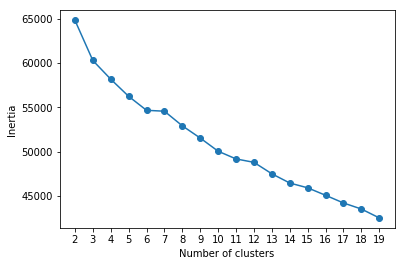

In [28]:
# Drop material_id from the db before performing scaling
fingerprint_db_numeric = fingerprint_db.drop(columns=['material_id','pretty_formula','spacegroup'],axis=1)

# Perform scaling
scaled_fingerprints_database, scaler = scale_fingerprints_database(fingerprints_db=fingerprint_db_numeric)

kmeans_inertia(scaled_fingerprints_database,
               n_cluster_min=2,
               n_cluster_max=20,
               random_state=42)

It is clear that a sharp reduction in slope occurs at n=3 clusters and this is perhaps what we should use as an optimum.
Another useful way to estimate an optimum number of clusters needed is to reduce the dimensionality of the dataset so that we can visually inspect to see if there is a distinct separation between sets of points in 2D/3D space.

In order to do this, we first cluster the scaled dataset and find cluster labels. We then perform a dimensionality reduction on the scaled dataset so that our dataset now contains 2 dimensions and the dataset can be plotted as a scatter plot. If we then color each point based on their cluster label we can begin to try and see if there is a clustering that is optimum in terms of distance between individual clusters.

Instead of doing this for n=2 through 20 as we did for the Elbow method, we could simply do it to decide if we need to use 2 through 5 clusters, since that range seems to be where most of the reduction in inertia happens.

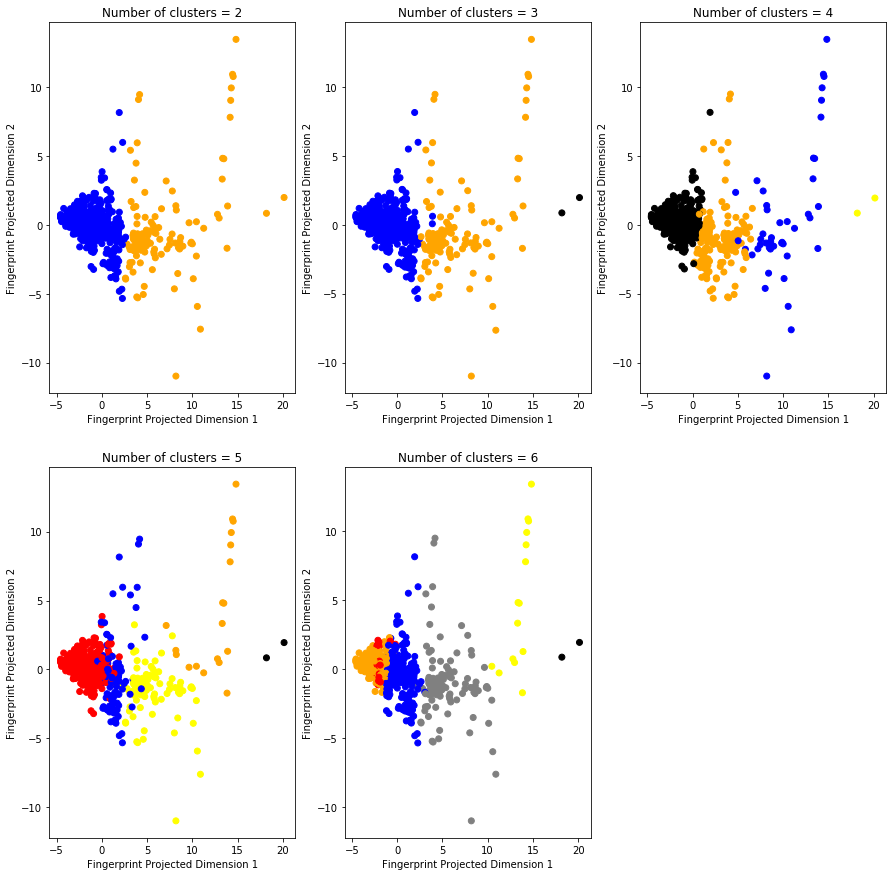

In [42]:
# Map cluster label to color
color_dict = {0:'orange',1:'blue',2:'black',3:'yellow',4:'red',5:'gray'}

#Plot  clusters by reducing fingerprint DB dimensions to 2
plt.figure(figsize=(15,15)) 
for n_clusters in range(2,7):
    kmeans_obj = KMeans(n_clusters=n_clusters,random_state=42)
    kmeans_obj.fit(scaled_fingerprints_database)
    cluster_labels = kmeans_obj.labels_
    proj_2d_fingerprints = perform_nD_projection(fingerprints_db=scaled_fingerprints_database,n_dimensions=4)
    plt.subplot(2,3,n_clusters-1)
    plt.scatter(proj_2d_fingerprints[:,0],
                proj_2d_fingerprints[:,2],
                color = [color_dict[cluster_label] for cluster_label in cluster_labels])
    plt.xlabel('Fingerprint Projected Dimension 1')
    plt.ylabel('Fingerprint Projected Dimension 2')
    plt.title('Number of clusters = {}'.format(n_clusters))

From the figure it is apparent that for n=2 and 3 there is minimal overlap between clusters. Combining the visuals with the inertia plot above, we can settle on n=3 as an optimum number of clusters. Having done this, we should first create a clustering object using n=3 so that we can use it later for a more detailed analysis.

In [241]:
kmeans_opt = KMeans(n_clusters=3,random_state=42)
kmeans_opt.fit(scaled_fingerprints_database)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)

In [81]:
fingerprint_db = get_fingerprint_db(dbtype='unary',fingerprint_name='GRDF',stats=('mean')) #Create fingerprint DB for elemental materials from the Materials Project

Initializing connection to Materials Project...
Creating materials database...
Creating Site Stats fingerprint object...
Creating fingerprint database...


In [82]:
fingerprint_db_copy = fingerprint_db.copy()
n_closest_materials(material_id='mp-30',fingerprint_db=fingerprint_db_copy,fingerprint_name='GRDF',stats=('mean'),num_closest=30)

Retrieving fingerprint for target material...
material fingerprint shape (1, 100)
fingerprints_db_no_material_id shape is (716, 100)
Index(['mean Gaussian center=0.0 width=0.05',
       'mean Gaussian center=0.1 width=0.05',
       'mean Gaussian center=0.2 width=0.05',
       'mean Gaussian center=0.30000000000000004 width=0.05',
       'mean Gaussian center=0.4 width=0.05',
       'mean Gaussian center=0.5 width=0.05',
       'mean Gaussian center=0.6000000000000001 width=0.05',
       'mean Gaussian center=0.7000000000000001 width=0.05',
       'mean Gaussian center=0.8 width=0.05',
       'mean Gaussian center=0.9 width=0.05',
       'mean Gaussian center=1.0 width=0.05',
       'mean Gaussian center=1.1 width=0.05',
       'mean Gaussian center=1.2000000000000002 width=0.05',
       'mean Gaussian center=1.3 width=0.05',
       'mean Gaussian center=1.4000000000000001 width=0.05',
       'mean Gaussian center=1.5 width=0.05',
       'mean Gaussian center=1.6 width=0.05',
       'm

,material_id,pretty_formula,distance
183,mp-30,Cu,0.000000
157,mp-8633,Cr,2.698852
177,mp-989695,Cu,10.656535
586,mp-1120747,Si,11.493170
178,mp-989782,Cu,15.023144
182,mp-1120774,Cu,15.597057
209,mp-150,Fe,17.104603
531,mp-10869,S,17.314842
210,mp-1194030,Fe,17.707618
223,mp-155,Gd,17.742496
